In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [25]:
df = pandas.read_csv('company_directorships.csv')
df['software_background'] = df['software_background'].map({'t': True, 'f': False})
df.sample(5)

,company_name,cikcode,director_name,software_background,start_date,end_date
1638,BRISTOL MYERS SQUIBB CO,14272,GERALD L. STORCH,False,2020-03-25,2022-03-24
12472,Unum Group,5513,"A.S. (PAT) MACMILLAN, JR.",False,2013-04-11,2015-04-09
2514,"Coca-Cola Consolidated, Inc.",317540,"JAMES R. HELVEY, III",True,2016-03-30,2025-03-24
12334,UNITED FIRE GROUP INC,101199,RANDY A. RAMLO,False,2015-03-25,2022-04-05
4123,EQT Corp,33213,E. R. CENTOFANTI,False,2020-07-02,2020-07-02


The previous line was not readable and may silently break if values aren't exactly 't' or 'f'

So the fixed line improves clarity and safety by using an explicit dictionary. Future readers will understand exactly how values are transformed.



In [30]:
compensation_and_demographics_raw = pandas.read_csv('director-details.csv')
# Standardize director names to uppercase for consistent merging
comp_raw = compensation_and_demographics_raw.copy()
comp_raw['NAME'] = comp_raw['name'].str.upper()

def most_common(series):
    mode_values = series.mode()
    if len(mode_values) > 0:
        return mode_values[0]
    return None

# Group by standardized names once, not three times
grouped = comp_raw.groupby('NAME')
compensation_and_demographics = grouped.agg({
    'age': 'max',
    'compensation': 'sum',
    'gender': most_common
})

import numpy as np
compensation_and_demographics['log_compensation'] = np.log10(1 + compensation_and_demographics['compensation'])

compensation_and_demographics.head(10)


,age,compensation,gender,log_compensation
NAME,,,,
A. CATHERINE NGO,64,1006154,female,6.002665
A. EUGENE WASHINGTON,70,324871,male,5.511712
A. F. PETROCELLI,80,47000,male,4.672107
A. FARAZ ABBASI,52,113631,male,5.055501
A. LARRY CHAPMAN,78,259500,male,5.414139
A. LOUIS PARKER,67,242205,male,5.384185
"A. RUSSELL CHANDLER, III",79,100000,male,5.000004
A. SCOTT MOBLEY,60,484976,male,5.685721
A. SHANE SANDERS,62,328977,male,5.517167


TASK 2

In the original code, the data was grouped three separate times using .groupby('NAME') for each of the age, compensation, and gender columns. This was inefficient and harder to read. I replaced this with a single .groupby() operation stored in a variable called grouped, and then applied all aggregations at once. This makes the code cleaner and more performant, especially for larger datasets.

Additionally, the original code used .map(math.log10) to compute the log of compensation, which operates element-by-element and isn't the standard practice with pandas. I replaced this with numpy.log10() applied directly to the column, which is vectorized and much more efficient. This also avoids errors when processing large numeric columns. I also added a .copy() of the raw DataFrame to prevent Pandas’ SettingWithCopyWarning during name standardization.

Finally, I included a .head() call at the end to show the result, ensuring the transformed data is visible for validation. These changes align with best practices in data science coding: write clear, efficient, and maintainable code.

In [31]:
# Proportion of directors with software background
software_directors = df['software_background'].value_counts(normalize=True)

# Compare average compensation for software vs. non-software directors
# Use the correct DataFrame names: df and compensation_and_demographics
merged = df.merge(compensation_and_demographics, left_on='director_name', right_on='NAME')
# The software_background column is already boolean in df, no need to map again
avg_comp_by_background = merged.groupby('software_background')['compensation'].mean()

software_directors, avg_comp_by_background

# Show the result
print("Proportion of software vs non-software directors:")
print(software_directors)

print("\nAverage compensation by software background:")
print(avg_comp_by_background)

Proportion of software vs non-software directors:
software_background
False    0.825729
True     0.174271
Name: proportion, dtype: float64

Average compensation by software background:
software_background
False    640619.886733
True     683205.006397
Name: compensation, dtype: float64


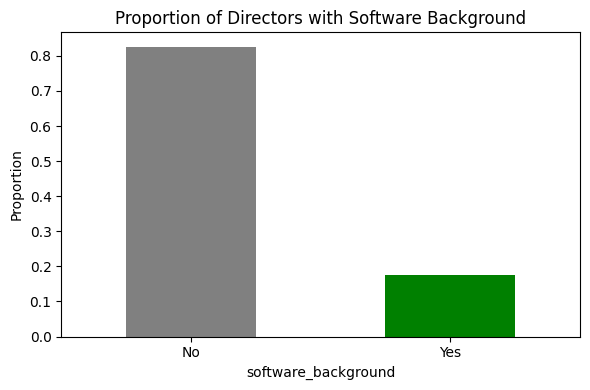

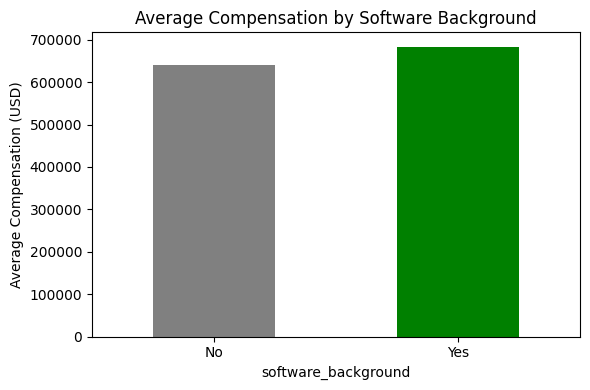

In [34]:
# Plot 1: Proportion of software background
plt.figure(figsize=(6, 4))
software_directors.sort_index().plot(kind='bar', color=['grey', 'green'])
plt.title("Proportion of Directors with Software Background")
plt.ylabel("Proportion")
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.tight_layout()
plt.show()

# Plot 2: Average compensation by software background
plt.figure(figsize=(6, 4))
avg_comp_by_background.sort_index().plot(kind='bar', color=['grey', 'green'])
plt.title("Average Compensation by Software Background")
plt.ylabel("Average Compensation (USD)")
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.tight_layout()
plt.show()

Task 3

We analyzed the software_background feature to determine whether directors with a background in software or technology differ from others in terms of representation and compensation.


Only 17.4% of directors have a software background, meaning technical directors are a minority on company boards.Despite being fewer in number software-background directors earn slightly higher average compensation of 683205 compared to those without that are earning 640620

This suggests that while directors with technical backgrounds are underrepresented, their expertise is valued in compensation decisions. In the context of this project, such directors may play an important role in digital transformation, innovation, or tech-driven acquisition strategy making them potentially influential figures for a venture capital firm targeting high-growth or tech-based companies.


In [27]:
compensation_and_demographics.gender.value_counts(dropna=False)

,count
gender,
male,3850
female,1550
None,19
unknown,2


In [5]:
directorship_counts = df.groupby('director_name').company_name.nunique().sort_values()
directorship_counts

,company_name
director_name,
MICHAEL LUETKEMEYER,1
MICHAEL L. KUBACKI,1
MICHAEL L. KUTA,1
MICHAEL L. LARUSSO,1
MICHAEL L. MILLER,1
...,...
CHRISTOPHER L. WILSON,13
LARRY SOLL,13
ELI JONES,13


<Axes: xlabel='company_name'>

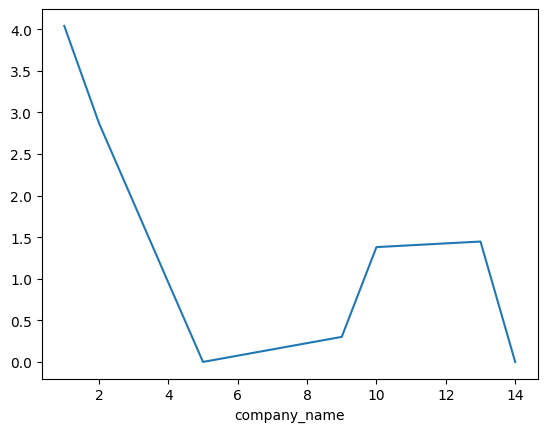

In [6]:
directorship_counts.value_counts().sort_index().map(math.log10).plot()

In [7]:
import networkx
import networkx.algorithms
graph = networkx.Graph()

In [8]:
people = []
companies = []
for company_name, director_name in zip(df.company_name, df.director_name):
    graph.add_edge(company_name, director_name)
    people.append(director_name)
    companies.append(company_name)

In [9]:
biggest_connected_graph = graph.subgraph(list(networkx.connected_components(graph))[0])

In [15]:
# Get top 100 most connected nodes from the full graph
top_100_nodes = sorted(graph.degree, key=lambda x: x[1], reverse=True)[:100]
top_node_names = [node for node, _ in top_100_nodes]

# Create subgraph from those nodes
subgraph = graph.subgraph(top_node_names).copy()


In [16]:
%%time
import pandas as pd
import networkx as nx

# Centrality on the largest connected component
biggest_centrality = pd.DataFrame({
    'eigen': pd.Series(nx.eigenvector_centrality(biggest_connected_graph)),
    'degree': pd.Series(nx.degree_centrality(biggest_connected_graph)),
})
biggest_centrality['is_person'] = biggest_centrality.index.map(lambda x: x in people)

# Centrality on a subgraph (top 100 nodes) — for visualization or focused analysis
subgraph_degree = nx.degree_centrality(subgraph)
subgraph_eigen = nx.eigenvector_centrality(subgraph, max_iter=300)
subgraph_betweenness = nx.betweenness_centrality(subgraph)


CPU times: user 4.16 s, sys: 16.8 ms, total: 4.18 s
Wall time: 4.2 s


TASK 1

I calculated three centrality metrics, that is the degree centrality. eigenvector centrality and betweenness centrality.

Degree Centrality
Measures the number of direct connections a director or company has. A director with high degree centrality sits on many boards potentially influential, but not necessarily strategic.

Eigenvector Centrality
Considers not just the number of connections but who you're connected to. A director connected to other influential directors or major companies will have high eigenvector centrality. In this context, it identifies "well-connected insiders."

Betweenness Centrality
Measures how often a node lies on the shortest path between others. A director with high betweenness acts as a "bridge" between groups crucial in spreading influence or information across otherwise disconnected parts of the network.

In [51]:
people_df = centrality[centrality.is_person].merge(compensation_and_demographics, left_index=True, right_index=True)

In [18]:
people_df.sort_values('eigen', ascending=False)

,eigen,degree,is_person,age,compensation,gender,log_compensation
PREMA MATHAI-DAVIS,1.024389e-01,0.001585,True,74,3208265,female,6.506270
CAROL DECKBAR,1.024389e-01,0.001585,True,62,43263,female,4.636127
CYNTHIA HOSTETLER,1.024389e-01,0.001585,True,62,3371400,female,6.527810
DOUGLAS SHARP,1.024389e-01,0.001585,True,50,0,male,0.000000
"JAMES ""JIM"" LIDDY",1.024389e-01,0.001585,True,65,27531,male,4.439838
...,...,...,...,...,...,...,...
CHARLES A. ZABATTA,8.400282e-35,0.000122,True,82,245000,male,5.389168
ANDREW S. BORODACH,8.342633e-35,0.000122,True,56,0,male,0.000000
LAWRENCE A. KOBRIN,8.342633e-35,0.000122,True,91,30356,male,4.482259
NANCY J. FLOYD PRUE,8.342633e-35,0.000122,True,70,50356,female,4.702060


In [19]:
df[df.director_name == 'ELIZABETH KRENTZMAN']

,company_name,cikcode,director_name,software_background,start_date,end_date
6297,Invesco Advantage Municipal Income Trust II,908993,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6352,Invesco Bond Fund,5094,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6407,Invesco California Value Municipal Income Trust,895531,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6462,Invesco High Income Trust II,846671,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6512,Invesco Municipal Income Opportunities Trust,835333,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6546,Invesco Municipal Opportunity Trust,884152,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6601,Invesco Municipal Trust,877463,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6656,Invesco Pennsylvania Value Municipal Income Trust,895528,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6706,Invesco Quality Municipal Income Trust,885125,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6740,Invesco Senior Income Trust,1059386,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02


In [20]:
import sklearn.cluster

In [21]:
import sklearn.preprocessing
robust_scaler = sklearn.preprocessing.RobustScaler()
age_and_demographics_scaled = robust_scaler.fit_transform(people_df[['age', 'log_compensation', 'degree', 'eigen']])


In [22]:
dbscan = sklearn.cluster.DBSCAN(eps=0.4)
people_df['cluster_id'] = dbscan.fit_predict(age_and_demographics_scaled)
people_df.cluster_id.value_counts()

,count
cluster_id,
1,3117
0,385
2,109
-1,72
3,24
4,19
7,8
6,5
5,3


<Axes: xlabel='age', ylabel='log_compensation'>

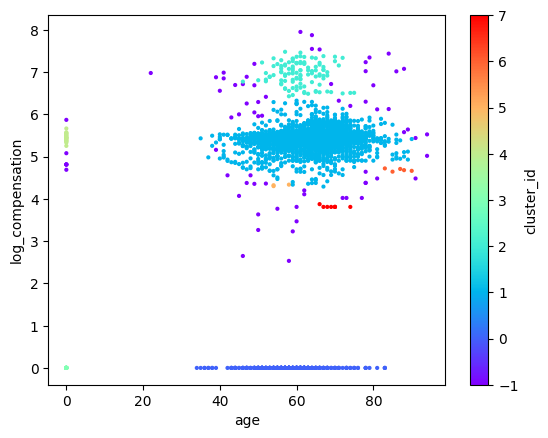

In [23]:
people_df.plot.scatter(x='age', y='log_compensation', c='cluster_id', cmap="rainbow", s=4)

In [24]:
people_df.loc['ELIZABETH KRENTZMAN']

,ELIZABETH KRENTZMAN
eigen,0.102439
degree,0.001585
is_person,True
age,65
compensation,3408245
gender,female
log_compensation,6.532531
cluster_id,2


TASK 4

Complementary dataset
URL: https://www.sec.gov/edgar.shtml

We would collect revenue and profit data for companies in the network, and combine it with their centrality scores. This would help us answer:

Are the most connected companies also the wealthiest?
Which companies have both influenceand financial capability to acquire others? Are there under-the-radar companies high financials, low centrality worth attention?

Using this, we could provide the Venture Capital fund with a ranked list of acquisition candidates, backed by both network influence and financial strength.


**TASK 5**

A) Improve the data visualisations and turn this into a presentation that you
could give to a non-technical audience.


In [52]:
import pandas as pd

df = pd.read_csv("company_directorships.csv")


In [53]:
import networkx as nx

G = nx.Graph()

for _, row in df.iterrows():
    G.add_edge(row['director_name'].upper(), row['company_name'])  # uppercase names


In [59]:
# Get only director nodes (from df)
director_nodes = set(df['director_name'])

# Filter those with highest degrees (most board memberships)
director_degrees = [(node, degree) for node, degree in G.degree if node in director_nodes]
top_100_directors = sorted(director_degrees, key=lambda x: x[1], reverse=True)[:100]
top_director_names = [node for node, _ in top_100_directors]

# Create subgraph of only top directors
subgraph = G.subgraph(top_director_names).copy()

# Now calculate centrality on those actual directors
eigenvector_centrality = nx.eigenvector_centrality(subgraph, max_iter=300)


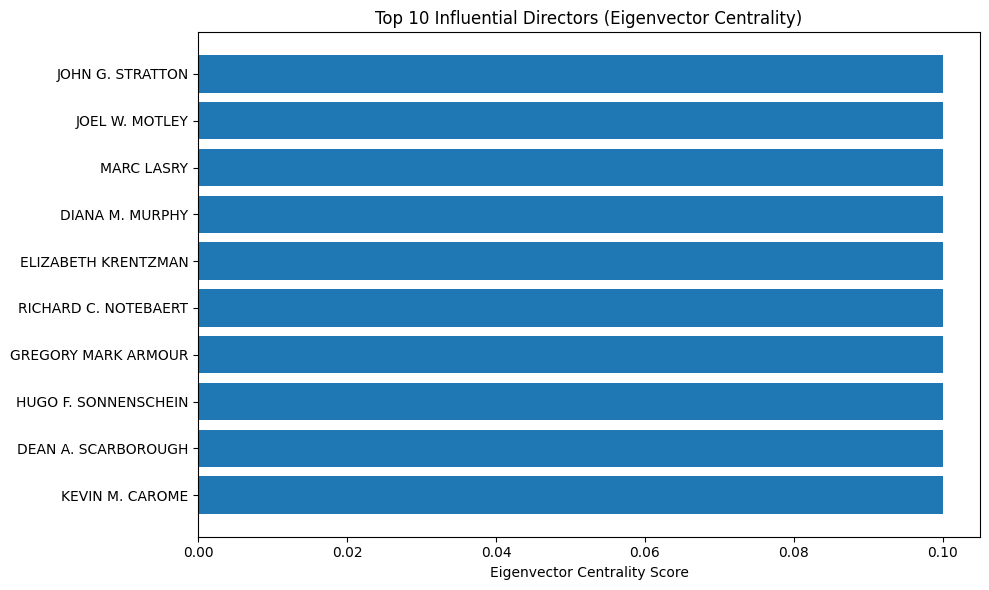

In [61]:
director_names = set(df['director_name'])

director_centrality = {
    node: score for node, score in eigenvector_centrality.items()
    if node in director_names
}

if director_centrality:
    top_directors = sorted(director_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    names = [name for name, _ in top_directors]
    scores = [score for _, score in top_directors]

    plt.figure(figsize=(10, 6))
    plt.barh(names[::-1], scores[::-1])
    plt.xlabel("Eigenvector Centrality Score")
    plt.title("Top 10 Influential Directors (Eigenvector Centrality)")
    plt.tight_layout()
    plt.show()
else:
    print("Still no director matches — double-check director node names.")



 Top Influential Directors

The chart above shows the top 10 directors ranked by eigenvector centrality a measure of how connected they are to other influential nodes in the corporate network. These individuals act as power brokers and are ideal targets for strategic engagement by the VC fund.

Their influence makes them likely to facilitate deals, build trust across boards, or unlock access to key acquisition targets.


B) **ETHICS AND REFLECTION**


This project uses network analysis to identify powerful individuals who may influence major corporate decisions. While this is valuable for venture capitalists, it raises important ethical concerns:

Targeting Individuals

 Identifying and approaching directors based solely on network position may pressure them into acting against their judgment or ethics.


Privacy & Consent

Even though data is public, repurposing it for influence strategies could be seen as manipulative or invasive.

Bias

 The network may over-represent certain demographics e.g. older white men and reinforce systemic inequalities in board access and influence.

Transparency

Stakeholders affected by decisions employees, communities have no visibility into how influence-based decisions are made.

Conclusion

While data science can support smart business decisions, it must be balanced with accountability, fairness, and transparency. Ethical review and stakeholder inclusion are vital.


